# Multi-Ticker Backtest

Tests the trading strategy on multiple unseen tickers and shows all results in one visualization.

In [1]:
import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import os
os.chdir(project_root)

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from copy import deepcopy
from tqdm import tqdm

from src.data.loader import load_and_filter_dataset
from src.data.preprocessor import preprocess_data
from src.data.feature_engineering import create_all_features
from src.data.dataset import StockDataset, create_sequences, time_series_split
from src.models.transformer_model import StockTransformer
from src.simulation.engine import BacktestEngine
from src.simulation.metrics import compute_metrics
from src.utils.config import load_config
from src.utils import config as _cfg
from sklearn.preprocessing import StandardScaler

In [3]:
# Configuration
config = load_config()

# List of tickers to test (NOT in training set)
TRAINING_TICKERS = set(config.data.tickers)  # ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

# Select 10 diverse tickers from different sectors
TEST_TICKERS = [
    "DIS",   # Entertainment
    "AMD",   # Tech (semiconductors)
    "JPM",   # Financials
    "JNJ",   # Healthcare
    "WMT",   # Retail
    "V",     # Financials (payments)
    "INTC",  # Tech (semiconductors)
    "CRM",   # Tech (software)
    "NFLX",  # Entertainment (streaming)
    "BAC",   # Financials (banking)
]

print(f"Training tickers: {sorted(TRAINING_TICKERS)}")
print(f"\nTesting on {len(TEST_TICKERS)} tickers:")
for i, ticker in enumerate(TEST_TICKERS, 1):
    print(f"  {i}. {ticker}")

Training tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT']

Testing on 10 tickers:
  1. DIS
  2. AMD
  3. JPM
  4. JNJ
  5. WMT
  6. V
  7. INTC
  8. CRM
  9. NFLX
  10. BAC


In [4]:
# Load simulation config
import yaml
config_path = _cfg.PROJECT_ROOT / "configs" / "default_config.yaml"
with config_path.open("r", encoding="utf-8") as f:
    raw_cfg = yaml.safe_load(f)
sim = raw_cfg.get("simulation", {})

initial_capital = float(sim.get("initial_capital", 100_000))
position_size_pct = float(sim.get("position_size_pct", 0.3))
entry_threshold_pct = float(sim.get("entry_threshold_pct", 0.5))
exit_threshold_pct = float(sim.get("exit_threshold_pct", -5.0))
commission_pct = float(sim.get("commission_pct", 0.1))
risk_free_rate_annual = float(sim.get("risk_free_rate_annual", 0.03))

print(f"Simulation config:")
print(f"  Initial capital: ${initial_capital:,.0f}")
print(f"  Position size: {position_size_pct*100:.0f}%")
print(f"  Entry threshold: {entry_threshold_pct}%")
print(f"  Exit threshold: {exit_threshold_pct}%")
print(f"  Commission: {commission_pct}%")

Simulation config:
  Initial capital: $100,000
  Position size: 30%
  Entry threshold: 0.5%
  Exit threshold: -5.0%
  Commission: 0.1%


In [5]:
# Load trained model
checkpoint_name = config.paths.checkpoint_file
checkpoint_path = _cfg.PROJECT_ROOT / config.paths.models_dir / checkpoint_name

print(f"Loading model from: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location="cpu")
state_dict = checkpoint["model_state_dict"]

print(f"Checkpoint: epoch {checkpoint.get('epoch', '?')}, val loss {checkpoint.get('score', '?'):.6f}")

# We'll determine input_dim from first ticker's data
d_model = state_dict["input_projection.weight"].shape[0]
n_layers = len([k for k in state_dict if "encoder.layers" in k and "self_attention.w_q.weight" in k])
n_heads = config.model.n_heads
d_ff = state_dict["encoder.layers.0.feed_forward.linear1.weight"].shape[0]

print(f"Model architecture: d_model={d_model}, n_layers={n_layers}, n_heads={n_heads}, d_ff={d_ff}")

Loading model from: C:\Users\vyoto\OneDrive\Desktop\CODE STUFF\Stock price prediction\models\checkpoints\best_model.pt
Checkpoint: epoch 29, val loss 0.014834
Model architecture: d_model=128, n_layers=4, n_heads=4, d_ff=512


In [6]:
# Load original training data to fit scaler (same as model training)
print("Loading original training data for scaler...")
from src.data.pipeline import extract_dataset
df_train_original, feature_columns = extract_dataset(config=config)
train_df_original, _, _ = time_series_split(
    df_train_original,
    train_split=config.data.train_split,
    val_split=config.data.val_split,
    test_split=config.data.test_split,
)

# Fit scaler on original training data
all_numeric_cols = feature_columns + ["close"]
scaler = StandardScaler()
scaler.fit(train_df_original[all_numeric_cols])
print(f"Scaler fitted on {len(train_df_original)} training samples")
print(f"Feature columns: {len(feature_columns)}")

Loading original training data for scaler...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)
Scaler fitted on 6936 training samples
Feature columns: 34


In [7]:
# Initialize model (input_dim will be set from feature_columns)
input_dim = len(feature_columns)
input_dim_checkpoint = state_dict["input_projection.weight"].shape[1]

if input_dim_checkpoint != input_dim:
    print(f"Input dim mismatch: checkpoint={input_dim_checkpoint}, current={input_dim}")
    print("Using compatible parameters only...")
    model = StockTransformer(
        input_dim=input_dim,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    model_dict = model.state_dict()
    compatible_dict = {k: v for k, v in state_dict.items()
                      if k in model_dict and model_dict[k].shape == v.shape}
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict, strict=False)
    print(f"Loaded {len(compatible_dict)}/{len(state_dict)} params")
else:
    model = StockTransformer(
        input_dim=input_dim_checkpoint,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    model.load_state_dict(state_dict)
    print("Model loaded successfully.")

model.eval()

Model loaded successfully.


StockTransformer(
  (input_projection): Linear(in_features=34, out_features=128, bias=True)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attention): MultiHeadAttention(
          (w_q): Linear(in_features=128, out_features=128, bias=True)
          (w_k): Linear(in_features=128, out_features=128, bias=True)
          (w_v): Linear(in_features=128, out_features=128, bias=True)
          (w_o): Linear(in_features=128, out_features=128, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.

In [8]:
# Test strategy on each ticker
results = []

for ticker in tqdm(TEST_TICKERS, desc="Testing tickers"):
    try:
        # Load data for this ticker
        test_config = deepcopy(config)
        test_config.data.tickers = [ticker]
        
        df_raw = load_and_filter_dataset(
            config=test_config,
            tickers=[ticker],
            start_date=test_config.data.start_date,
            end_date=test_config.data.end_date,
        )
        
        if len(df_raw) == 0:
            print(f"⚠️  No data for {ticker}, skipping...")
            continue
        
        # Preprocess
        df_processed, _ = preprocess_data(
            df_raw,
            handle_missing=True,
            missing_method="forward_fill",
            handle_outliers_flag=True,
            outliers_method="clip",
            normalize=False,
            date_column="date",
            symbol_column="symbol",
        )
        
        # Create features
        df_features = create_all_features(
            df_processed,
            price_column="close",
            high_column="high",
            low_column="low",
            volume_column="volume",
            date_column="date",
            symbol_column="symbol",
            windows=test_config.data.features.windows,
            lags=[1, 2, 3, 5, 10] if test_config.data.features.lag_features else [],
            add_technical=test_config.data.features.technical_indicators,
            add_lags=test_config.data.features.lag_features,
            add_temporal=test_config.data.features.temporal_features,
            add_volume=True,
            simplified=test_config.data.features.simplified,
        )
        
        df_features = df_features.dropna()
        
        if len(df_features) == 0:
            print(f"⚠️  No valid data after feature engineering for {ticker}, skipping...")
            continue
        
        # Apply scaler
        df_features[all_numeric_cols] = scaler.transform(df_features[all_numeric_cols])
        
        # Split into train/val/test
        train_df, val_df, test_df = time_series_split(
            df_features,
            train_split=test_config.data.train_split,
            val_split=test_config.data.val_split,
            test_split=test_config.data.test_split,
        )
        
        if len(test_df) < config.data.context_length + 10:
            print(f"⚠️  Not enough test data for {ticker}, skipping...")
            continue
        
        # Create dataset
        test_data = test_df[feature_columns].values
        test_targets = test_df["close"].values.reshape(-1, 1)
        
        test_X, test_y = create_sequences(
            np.column_stack([test_data, test_targets]),
            config.data.context_length,
            config.data.prediction_horizon,
        )
        
        test_X = test_X[:, :, :-1]
        if config.data.prediction_horizon > 1:
            test_y = test_y[:, :, -1]
        else:
            test_y = test_y[:, -1, -1]
            if test_y.ndim == 0:
                test_y = test_y.reshape(-1, 1)
        
        test_dataset = StockDataset(test_X, test_y, config.data.context_length, config.data.prediction_horizon)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        # Generate predictions
        predictions = []
        prices_list = []
        
        with torch.no_grad():
            for batch in test_loader:
                features, targets = batch
                preds = model(features)
                predictions.append(preds.cpu().numpy())
                prices_list.append(targets.cpu().numpy())
        
        pred_next = np.concatenate(predictions).ravel()
        prices = np.concatenate(prices_list).ravel()
        
        # Align prices and predictions
        test_prices = test_df["close"].values
        context_length = config.data.context_length
        prices_for_backtest = test_prices[context_length:]
        
        min_len = min(len(pred_next), len(prices_for_backtest))
        prices = prices_for_backtest[:min_len]
        pred_next = pred_next[:min_len]
        
        # Run backtest
        engine = BacktestEngine(
            initial_capital=initial_capital,
            position_size_pct=position_size_pct,
            entry_threshold_pct=entry_threshold_pct,
            exit_threshold_pct=exit_threshold_pct,
            commission_pct=commission_pct,
        )
        
        result = engine.run(prices=prices, predictions=pred_next)
        
        metrics = compute_metrics(
            result,
            initial_capital=initial_capital,
            risk_free_rate_annual=risk_free_rate_annual,
            prices=prices,
        )
        
        results.append({
            "ticker": ticker,
            "equity_curve": result.equity_curve,
            "prices": prices,
            "total_return_pct": metrics.total_return_pct,
            "sharpe_ratio": metrics.sharpe_ratio_annual,
            "max_drawdown_pct": metrics.max_drawdown_pct,
            "num_trades": metrics.num_trades,
            "buy_hold_return_pct": metrics.buy_and_hold_return_pct,
            "excess_return_pct": metrics.excess_return_vs_bh_pct,
            "final_equity": result.equity_curve[-1],
        })
        
    except Exception as e:
        print(f"❌ Error processing {ticker}: {e}")
        continue

print(f"\n✅ Successfully tested {len(results)} tickers")

Testing tickers:   0%|          | 0/10 [00:00<?, ?it/s]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  10%|█         | 1/10 [00:01<00:16,  1.80s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  20%|██        | 2/10 [00:03<00:14,  1.82s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  30%|███       | 3/10 [00:05<00:11,  1.68s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  40%|████      | 4/10 [00:06<00:08,  1.50s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)


Testing tickers:  50%|█████     | 5/10 [00:07<00:06,  1.29s/it]

Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (0, 25)
⚠️  No data for WMT, skipping...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)


Testing tickers:  60%|██████    | 6/10 [00:08<00:04,  1.17s/it]

Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (0, 25)
⚠️  No data for V, skipping...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  70%|███████   | 7/10 [00:09<00:03,  1.21s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2578, 25)


Testing tickers:  80%|████████  | 8/10 [00:10<00:02,  1.22s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  90%|█████████ | 9/10 [00:11<00:01,  1.22s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


✅ Successfully tested 8 tickers


In [9]:
# Create summary table
df_results = pd.DataFrame(results)

print("=" * 80)
print("BACKTEST RESULTS SUMMARY")
print("=" * 80)
print(f"\nTested {len(results)} tickers")
print(f"\n{'Ticker':<8} {'Return %':<12} {'B&H Return %':<15} {'Excess %':<12} {'Sharpe':<10} {'Max DD %':<12} {'Trades':<8}")
print("-" * 80)

for _, row in df_results.iterrows():
    print(f"{row['ticker']:<8} {row['total_return_pct']:>10.2f}% {row['buy_hold_return_pct']:>13.2f}% {row['excess_return_pct']:>10.2f}% {row['sharpe_ratio']:>8.3f} {row['max_drawdown_pct']:>10.2f}% {row['num_trades']:>6}")

print("-" * 80)
print(f"{'AVERAGE':<8} {df_results['total_return_pct'].mean():>10.2f}% {df_results['buy_hold_return_pct'].mean():>13.2f}% {df_results['excess_return_pct'].mean():>10.2f}% {df_results['sharpe_ratio'].mean():>8.3f} {df_results['max_drawdown_pct'].mean():>10.2f}% {df_results['num_trades'].mean():>6.0f}")

# Win rate
winning_trades = (df_results['total_return_pct'] > 0).sum()
win_rate = winning_trades / len(df_results) * 100
print(f"\nWin Rate: {winning_trades}/{len(results)} ({win_rate:.1f}%)")

# Beat buy & hold
beat_bh = (df_results['excess_return_pct'] > 0).sum()
beat_bh_rate = beat_bh / len(df_results) * 100
print(f"Beat Buy & Hold: {beat_bh}/{len(results)} ({beat_bh_rate:.1f}%)")

BACKTEST RESULTS SUMMARY

Tested 8 tickers

Ticker   Return %     B&H Return %    Excess %     Sharpe     Max DD %     Trades  
--------------------------------------------------------------------------------
DIS            3.62%        -12.16%      15.77%    0.036       9.46%      1
AMD          -48.92%        162.96%    -211.87%   -1.393      50.24%      1
JPM            3.52%        -11.82%      15.34%    0.047       8.87%      1
JNJ           -3.04%         10.02%     -13.06%   -0.637       8.25%      1
INTC          -3.23%         10.68%     -13.91%   -0.262      11.75%      1
CRM           -9.28%         30.85%     -40.13%   -0.861      15.10%      1
NFLX          -9.62%         31.98%     -41.61%   -0.902      17.56%      1
BAC            4.27%        -14.35%      18.62%    0.096      10.11%      1
--------------------------------------------------------------------------------
AVERAGE       -7.84%         26.02%     -33.86%   -0.485      16.42%      1

Win Rate: 3/8 (37.5%)
Bea

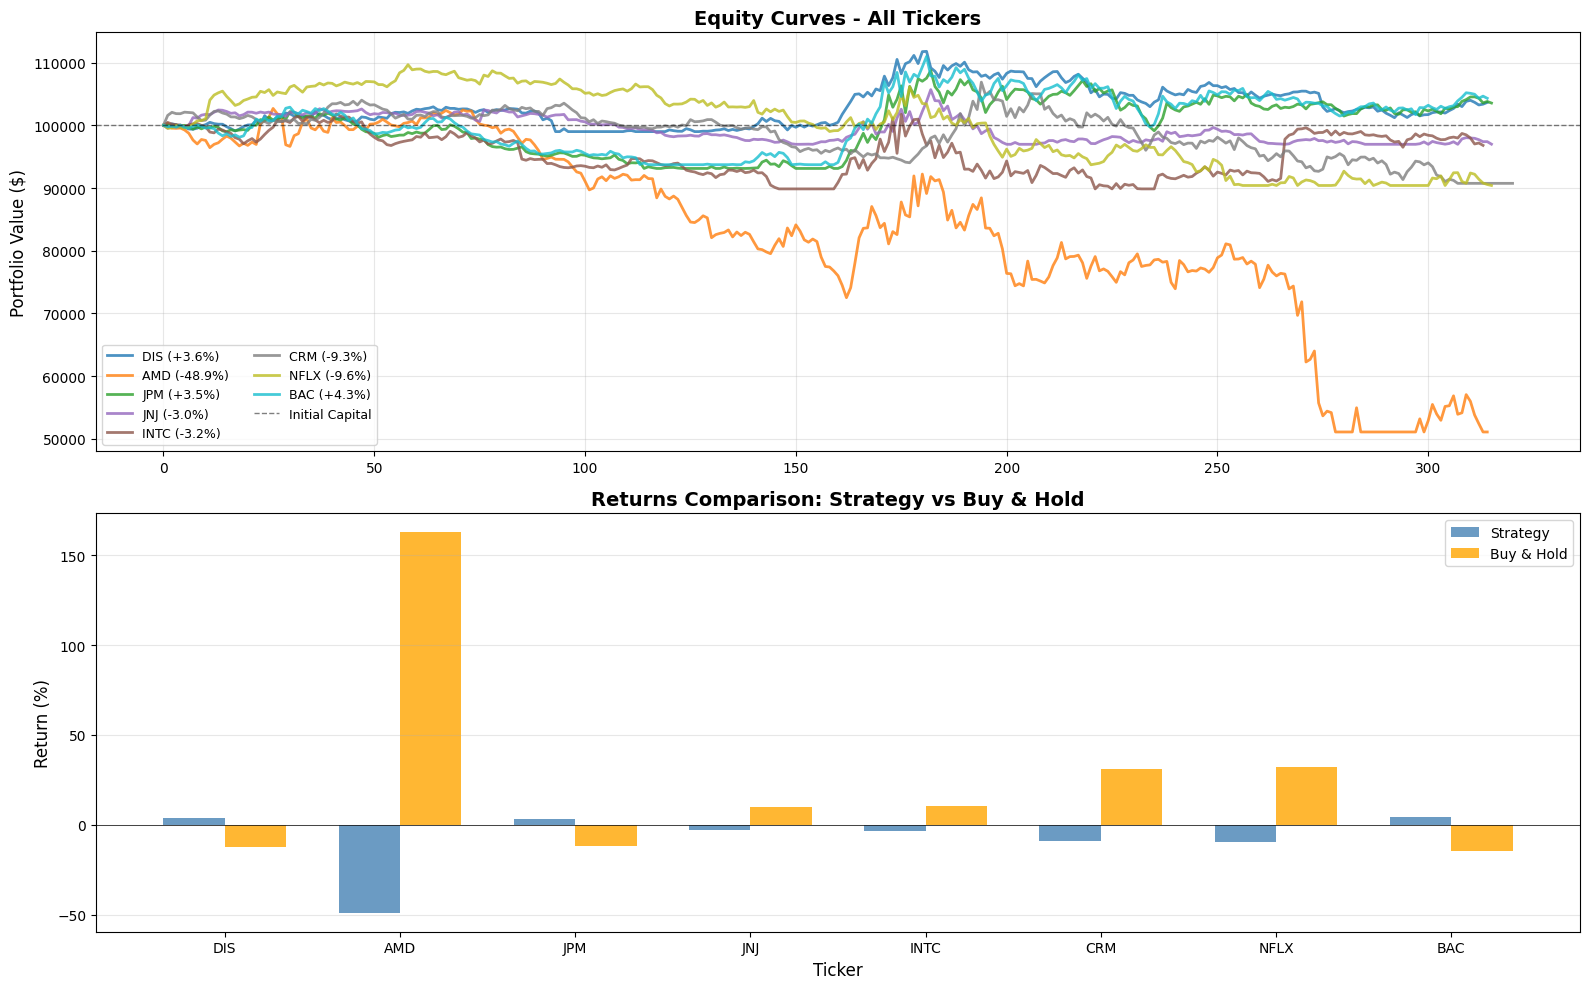


Average Strategy Return: -7.84%
Average Buy & Hold Return: 26.02%
Average Excess Return: -33.86%


: 

In [ ]:
# Visualize all equity curves
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

ax1 = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

for i, result in enumerate(results):
    ticker = result['ticker']
    equity = result['equity_curve']
    return_pct = result['total_return_pct']
    
    # Normalize to start at 100k for comparison
    equity_normalized = equity / equity[0] * initial_capital
    
    ax1.plot(equity_normalized, label=f"{ticker} ({return_pct:+.1f}%)", 
             color=colors[i], linewidth=2, alpha=0.8)

ax1.axhline(y=initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.set_title('Equity Curves - All Tickers', fontsize=14, fontweight='bold')
ax1.legend(loc='best', ncol=2, fontsize=9)
ax1.grid(True, alpha=0.3)

# Second subplot: Returns comparison
ax2 = axes[1]
tickers = [r['ticker'] for r in results]
strategy_returns = [r['total_return_pct'] for r in results]
bh_returns = [r['buy_hold_return_pct'] if r['buy_hold_return_pct'] is not None else 0 for r in results]

x = np.arange(len(tickers))
width = 0.35

bars1 = ax2.bar(x - width/2, strategy_returns, width, label='Strategy', color='steelblue', alpha=0.8)
bars2 = ax2.bar(x + width/2, bh_returns, width, label='Buy & Hold', color='orange', alpha=0.8)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Ticker', fontsize=12)
ax2.set_ylabel('Return (%)', fontsize=12)
ax2.set_title('Returns Comparison: Strategy vs Buy & Hold', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(tickers)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show() 

print(f"\n{'='*80}")
print(f"Average Strategy Return: {df_results['total_return_pct'].mean():.2f}%")
print(f"Average Buy & Hold Return: {df_results['buy_hold_return_pct'].mean():.2f}%")
print(f"Average Excess Return: {df_results['excess_return_pct'].mean():.2f}%")
print(f"{'='*80}")